## Học phần: Thị giác máy tính
#### Nhóm 9: 
- Trịnh Quốc Dân - 22E1020014
- Lê Quý Minh Quang - 22E1020007
- Phạm Phước Bảo Tín - 22E1020021

## Mô tả dữ liệu
- Bộ dữ liệu về phân loại "Shoe", "Sandal", "Boot". Nguồn dữ liệu : Kaggle ([Shoe vs Sandal vs Boot Image Dataset](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images?fbclid=IwZXh0bgNhZW0CMTEAAR4Qhm5prfJKpfYH3kwbWi-Tcsk1Q1AHnBqh4scpOWhT4CTERDLwisuTuvNcDg_aem_8fGVUmMtZuHu_Cmj3jxaCg)).
- Ba lớp 3 thư mục riêng, mỗi thư mục 5000 ảnh.


## Chuẩn bị dữ liệu  + Theo dõi từng k, neen chọn bước nhảy là +2

In [42]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

# ======================
# 1. Chuẩn bị dữ liệu
# ======================
data_dir = r"D:\datasets\ShoeSandalBoot"
classes = ["Shoe", "Sandal", "Boot"]

X, y = [], []
img_size = (64, 64)  # giảm kích thước ảnh 

for c in classes:
    folder = os.path.join(data_dir, c)
    for img_file in os.listdir(folder):  # lấy full 5000 ảnh / class
        img = load_img(os.path.join(folder, img_file), target_size=img_size, color_mode="grayscale")
        arr = img_to_array(img).flatten() / 255.0
        X.append(arr)
        y.append(c)

X = np.array(X, dtype=np.float32)  # ép về float32 cho nhẹ

# ======================
# 2. Chuẩn hoá + PCA
# ======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

pca = PCA(n_components=200, random_state=42)  # giảm chiều
X_pca = pca.fit_transform(X_scaled)

# ======================
# 3. Chia train/test
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)



k=1, Accuracy=0.9240
k=3, Accuracy=0.9253
k=5, Accuracy=0.9197
k=7, Accuracy=0.9187
k=9, Accuracy=0.9143
k=11, Accuracy=0.9107
k=13, Accuracy=0.9090


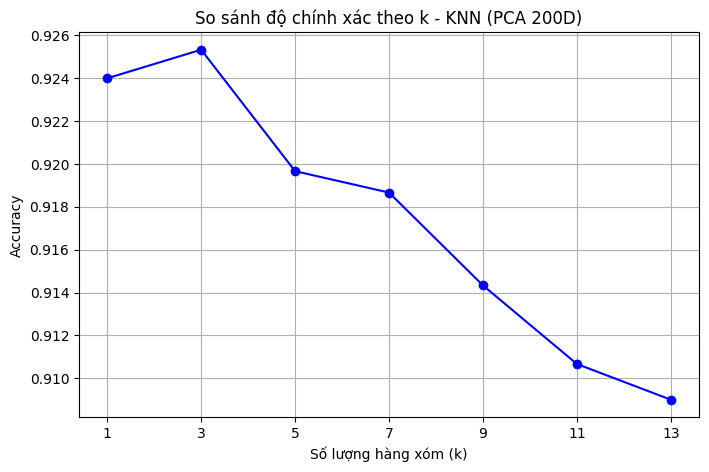

In [43]:
# ======================
# So sánh accuracy theo k
# ======================
k_values = range(1, 15, 2)  # k lẻ: 1,3,5,...13
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="distance")
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker="o", linestyle="-", color="b")
plt.xticks(k_values)
plt.xlabel("Số lượng hàng xóm (k)")
plt.ylabel("Accuracy")
plt.title("So sánh độ chính xác theo k - KNN (PCA 200D)")
plt.grid(True)
plt.show()

Chọn k=3 tốt nhất

🔹 Accuracy: 0.9253333333333333

🔹 Classification Report:
               precision    recall  f1-score   support

        Shoe       0.91      0.98      0.94      1000
      Sandal       0.95      0.87      0.91      1000
        Boot       0.91      0.93      0.92      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.92      3000
weighted avg       0.93      0.93      0.92      3000



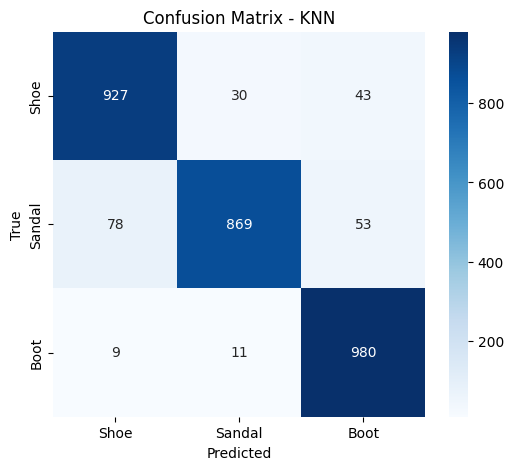

In [44]:
# ======================
# 4. Huấn luyện KNN
# ======================
k = 3
knn_k = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="distance")
knn_k.fit(X_train, y_train)

# ======================
# 5. Đánh giá mô hình
# ======================
y_pred = knn_k.predict(X_test)

print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred, labels=classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


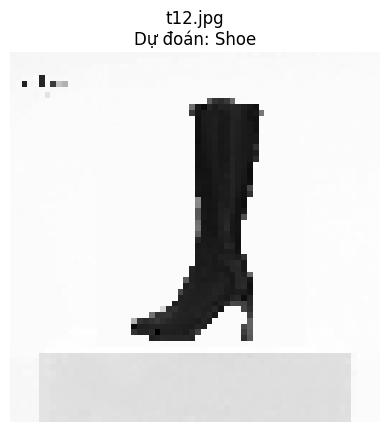

t12.jpg → Shoe


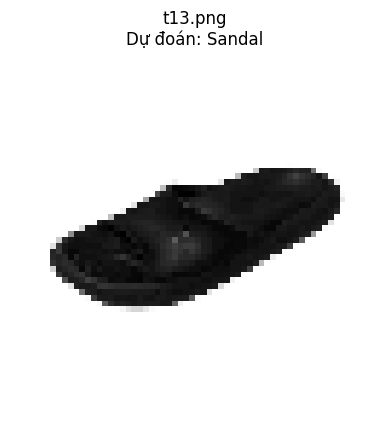

t13.png → Sandal


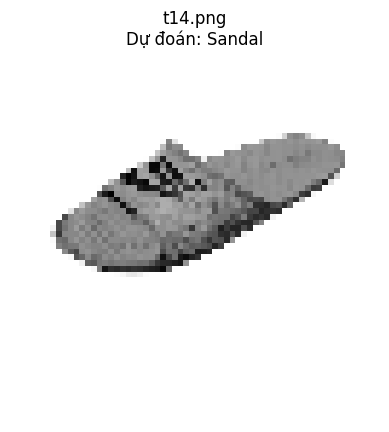

t14.png → Sandal


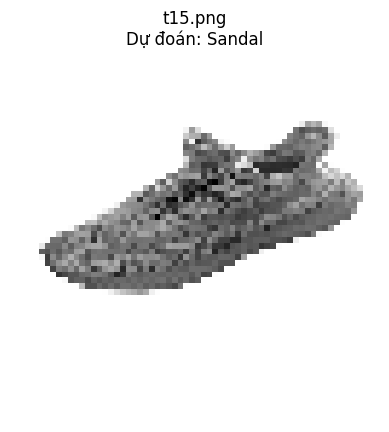

t15.png → Sandal


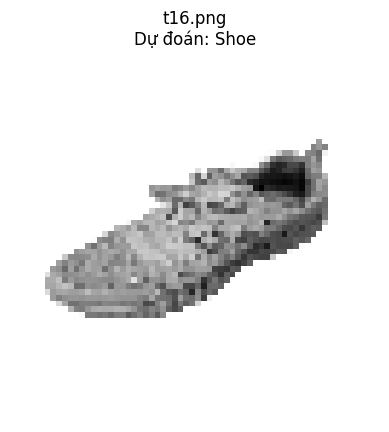

t16.png → Shoe


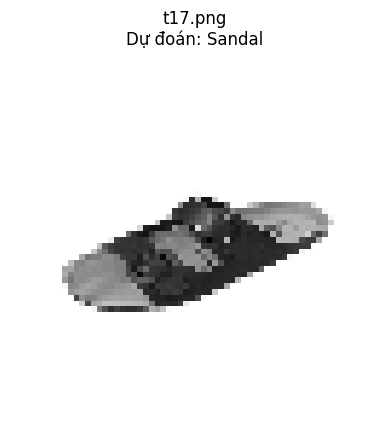

t17.png → Sandal


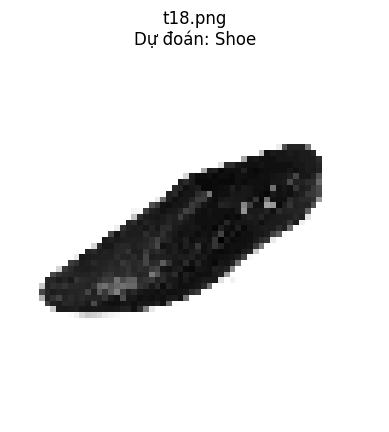

t18.png → Shoe


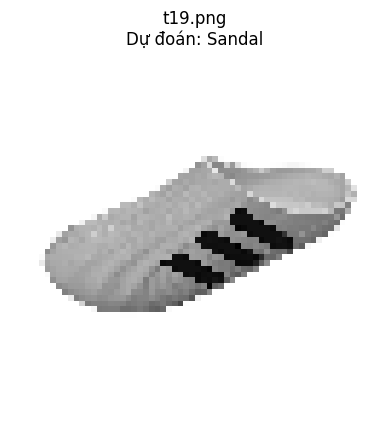

t19.png → Sandal


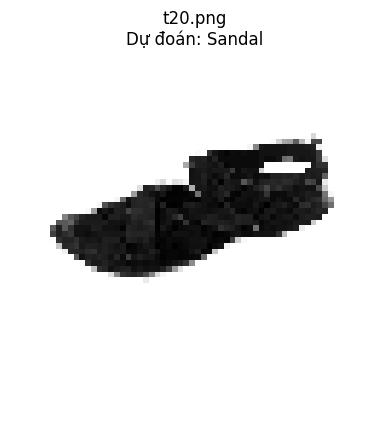

t20.png → Sandal


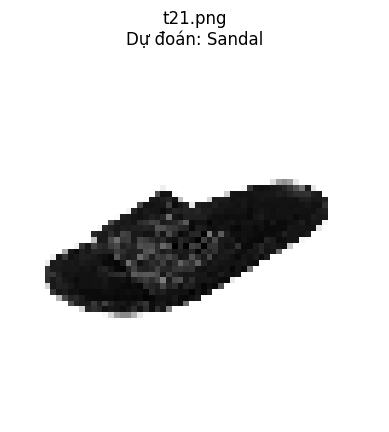

t21.png → Sandal


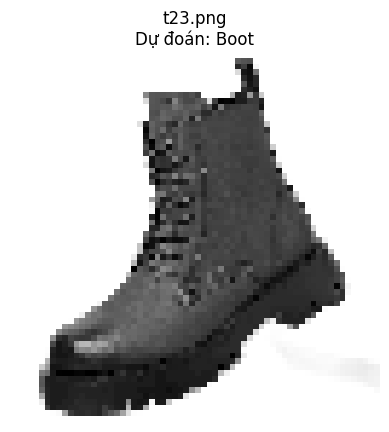

t23.png → Boot


[('t12.jpg', np.str_('Shoe')),
 ('t13.png', np.str_('Sandal')),
 ('t14.png', np.str_('Sandal')),
 ('t15.png', np.str_('Sandal')),
 ('t16.png', np.str_('Shoe')),
 ('t17.png', np.str_('Sandal')),
 ('t18.png', np.str_('Shoe')),
 ('t19.png', np.str_('Sandal')),
 ('t20.png', np.str_('Sandal')),
 ('t21.png', np.str_('Sandal')),
 ('t23.png', np.str_('Boot'))]

In [47]:
def predict_folder(folder_path, limit=None):
    results = []
    count = 0
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        if img is None:
            continue

        img = cv2.resize(img, img_size)                   
        img_flat = img.flatten().reshape(1, -1) / 255.0  

        # Scale + PCA (phải giống bước train)
        img_scaled = scaler.transform(img_flat)
        img_pca = pca.transform(img_scaled)

        prediction = knn_k.predict(img_pca)[0]

        results.append((filename, prediction))

        plt.imshow(img, cmap="gray")
        plt.title(f"{filename}\nDự đoán: {prediction}")
        plt.axis("off")
        plt.show()

        print(f"{filename} → {prediction}")

        count += 1
        if limit and count >= limit:
            break
    
    return results
# Thử dự đoán trên thư mục mới (chứa ảnh cần dự đoán)
new_data_dir = r"D:\datasets\test"
predict_folder(new_data_dir, limit=16)
